# SVM(Support Vector Machine)

In [91]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_confusion_matrix, classification_report

from sklearn.pipeline import Pipeline, make_pipeline
#import scikitplot as skplt
from joblib import dump, load

In [93]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim(); ylim = ax.get_ylim()
    x = np.linspace(xlim[0], xlim[1], 30); y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], 
               alpha=0.5, linestyles=['--', '-', '--'])
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1],
                 s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim); ax.set_ylim(ylim)

## **1. SVM 이해**
- 2차원에서 설명

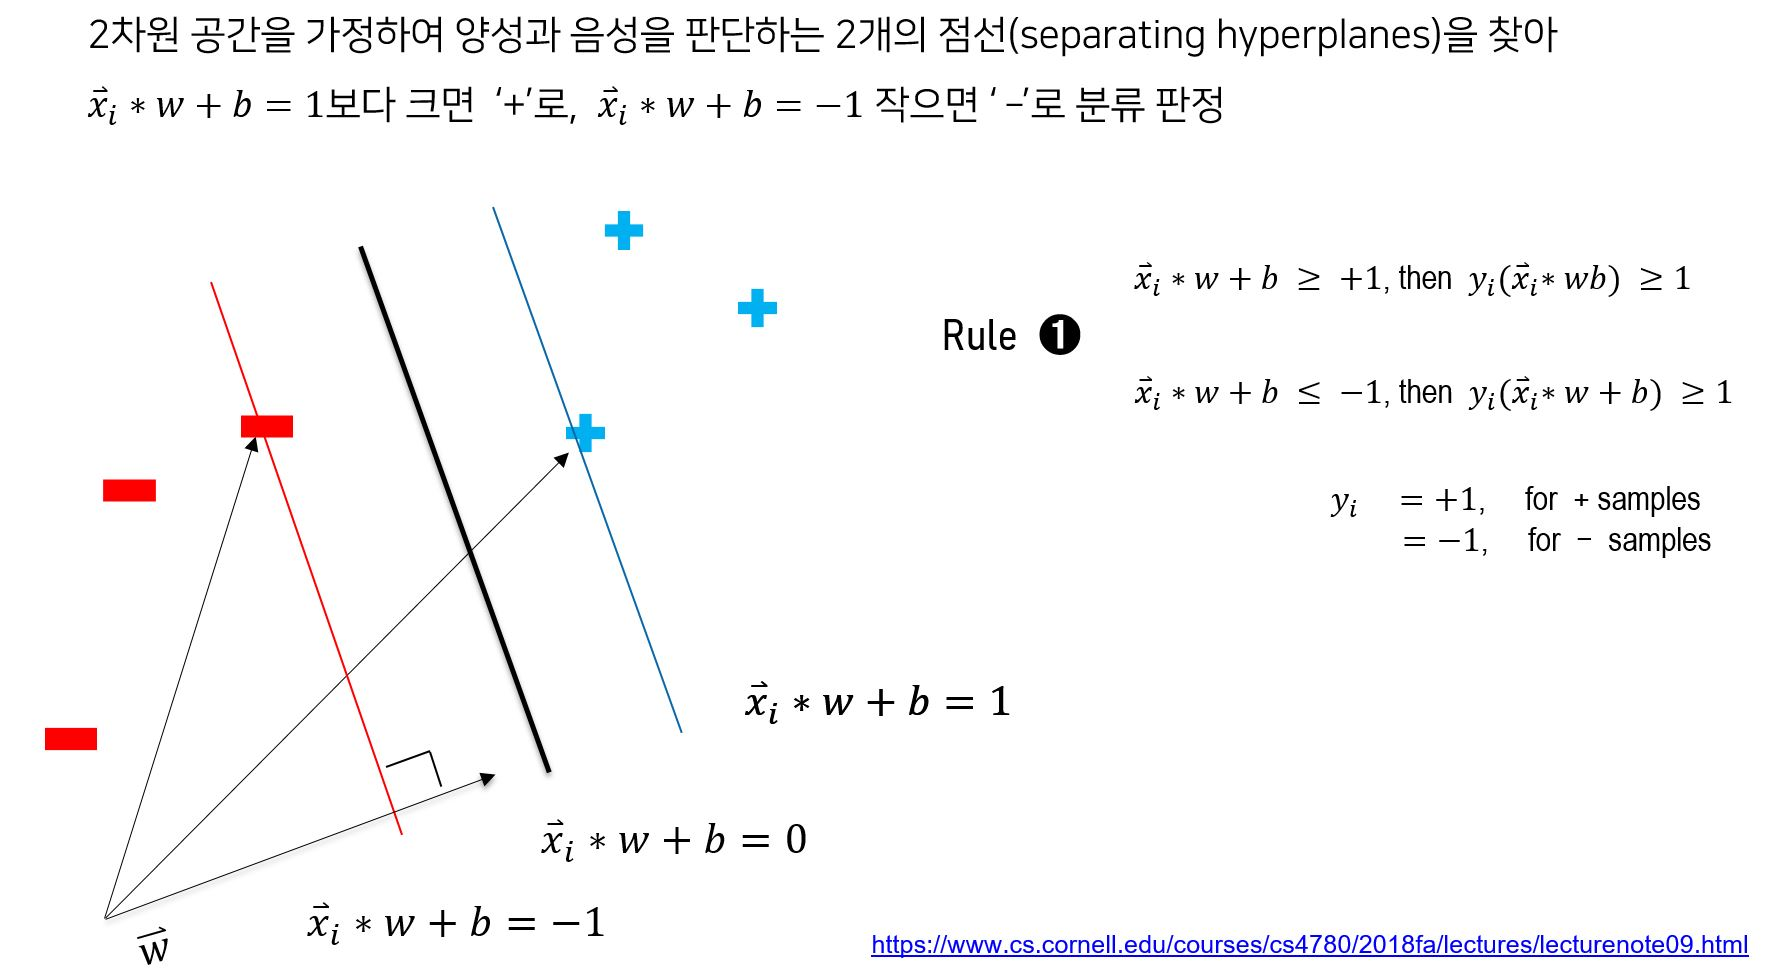

In [ ]:
Image(filename=dir_path +'/svc01.jpg', width=width, height=height)

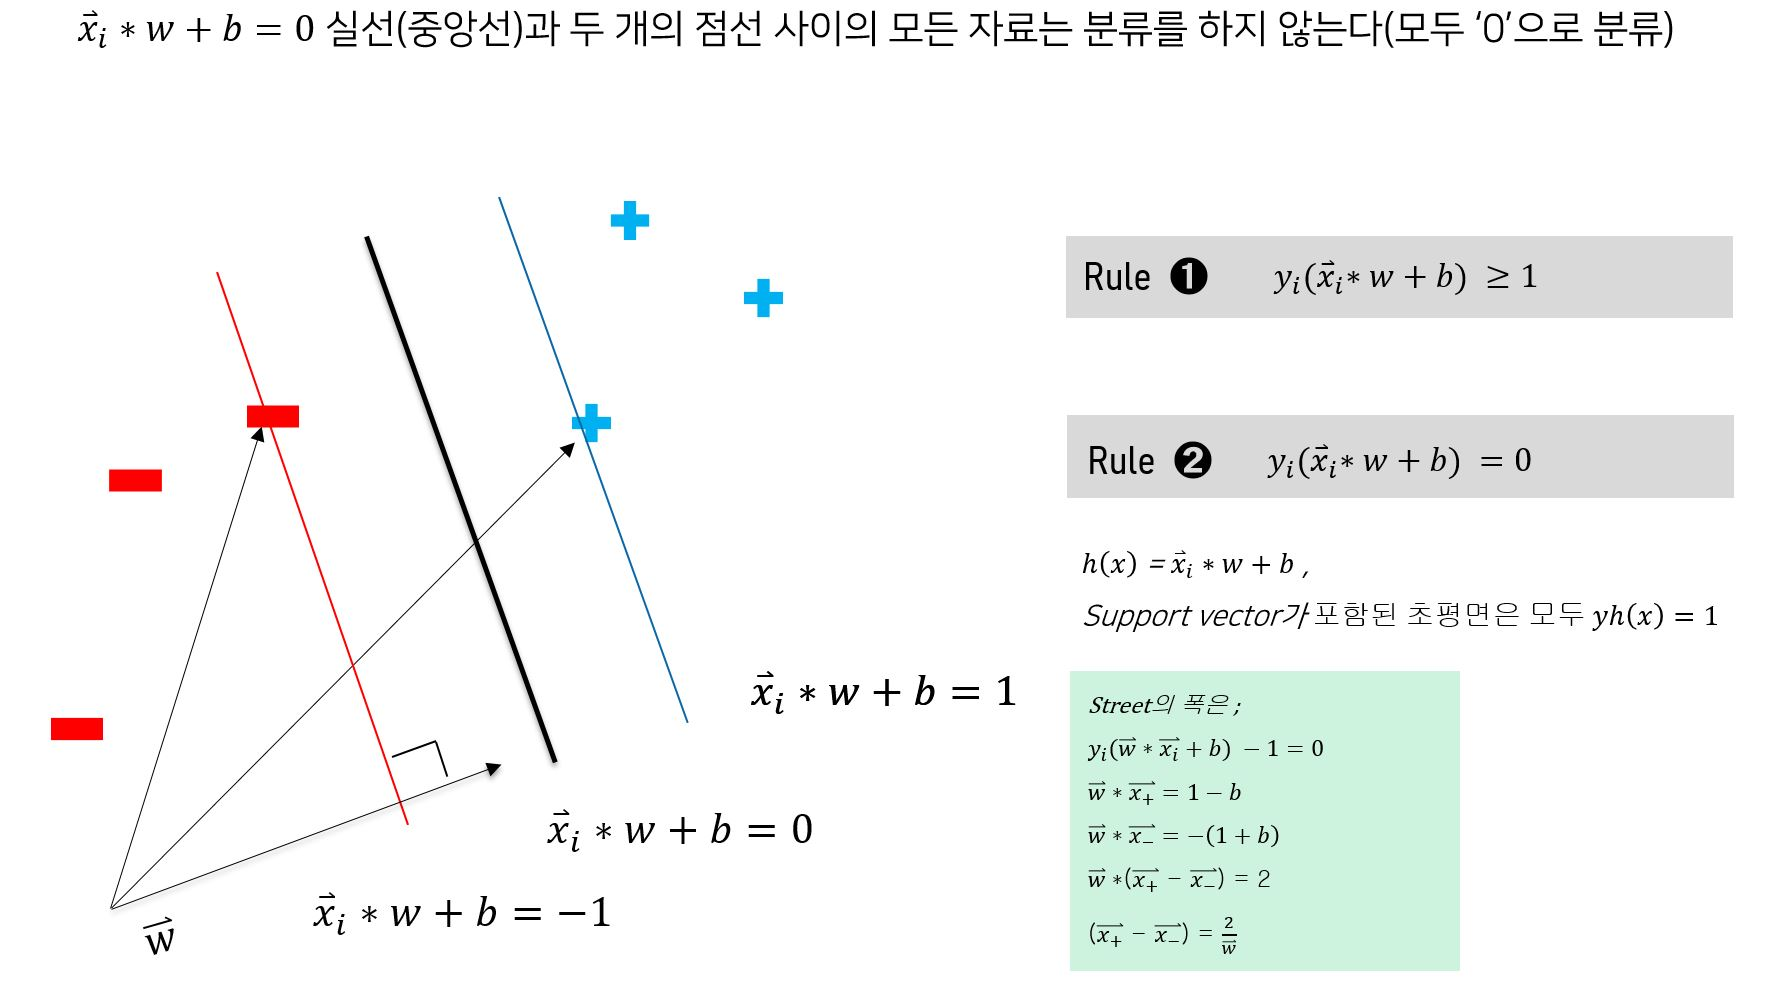

In [ ]:
Image(filename=dir_path +'/svc02.jpg', width=width, height=height)

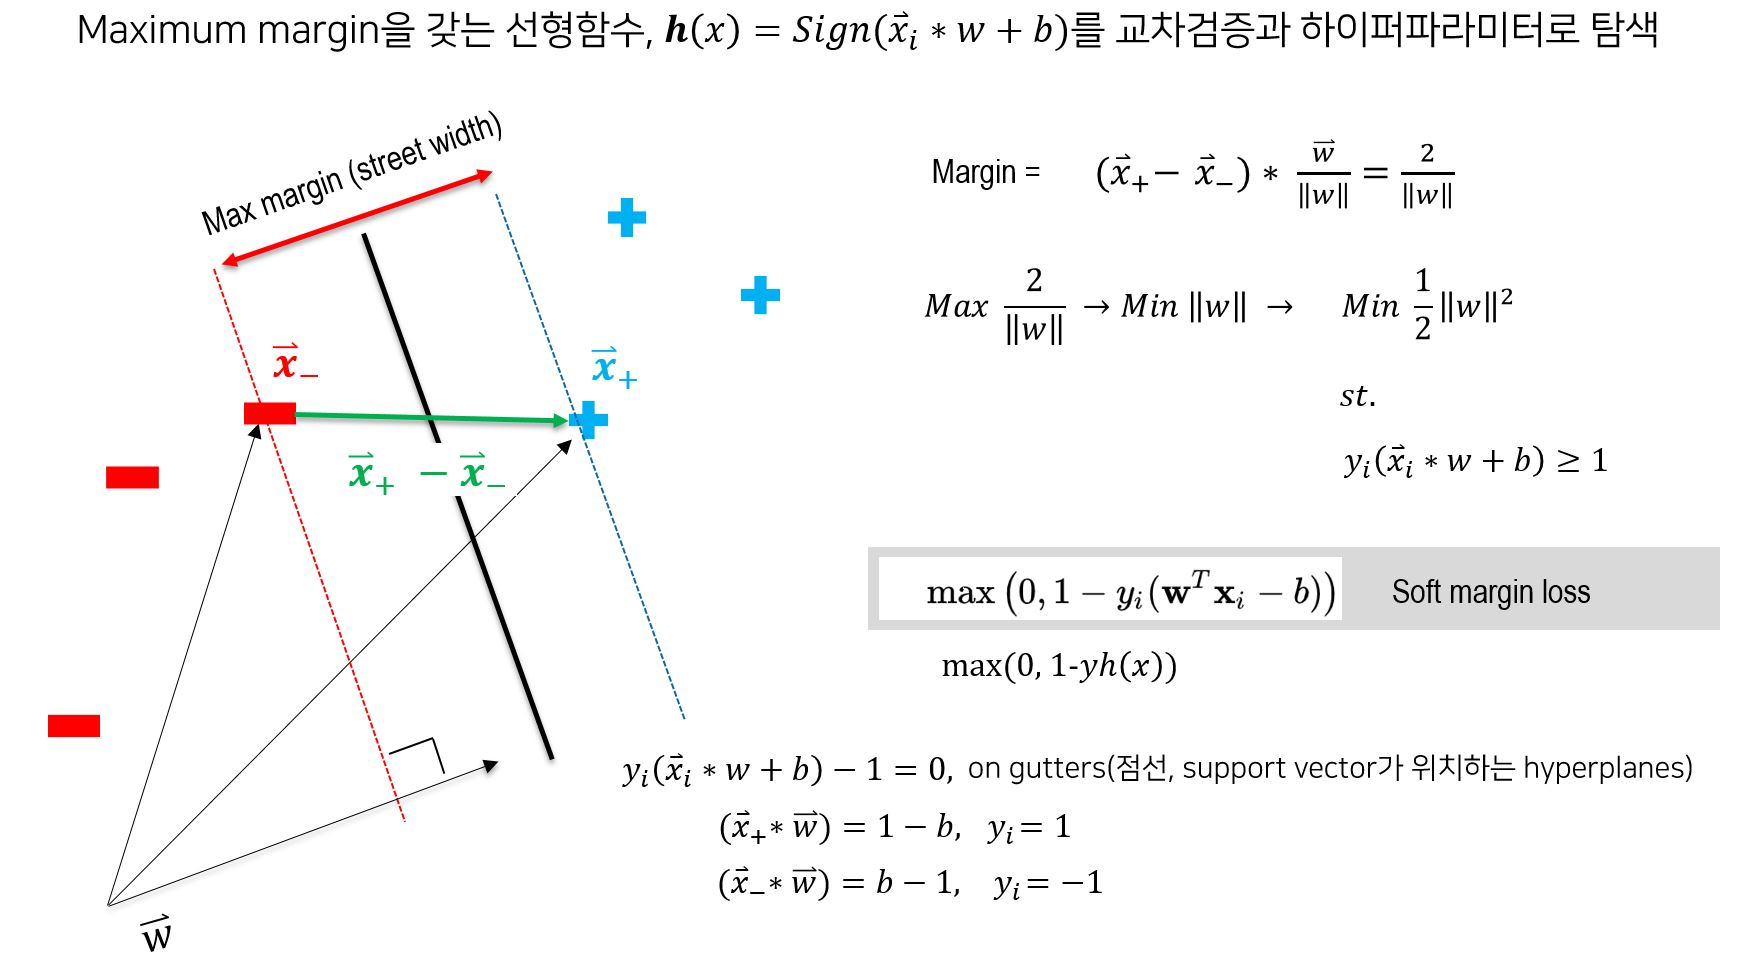

In [ ]:
Image(filename=dir_path +'/svc03.jpg', width=width, height=height)

### Minimize ||W||
### subject to 

<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/c2f2091faefb56179a2d4720935f5a69a20b246d'>

- Unseeen data에 대한 예측 성능을 높이기 위해 일반화된 모델은 직선(초평면)과 가장 거리가 먼 wx+b =0 직선이다.
   * Finding w, b is to optimize SVM algorithm.

## Sign function 
$f(x) = sign(wx-b)$ 

- where sign is a mathematical operator that takes any value as input and returns +1 if the input is a positive number or −1 if the input is a negative number.
- The goal of the learning algorithm — SVM in this case — is to leverage the dataset and find the optimal values $w^*$ and $b^*$ for parameters w and b. 
- Once the learning algorithm identifies these optimal values, the model $f(x)$ is then defined as:

$f(x) = sign(w^*x-b^*)$

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Signum_function.svg/450px-Signum_function.svg.png' width=300>

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/450px-SVM_margin.png'>

## **2. SVM 분류 알고리즘**

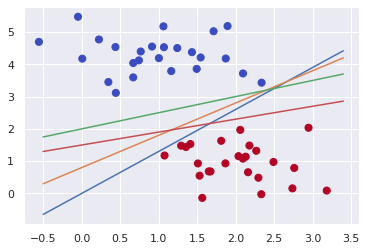

In [98]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm');
X_fit = np.arange(-0.5, 3.5, 0.1)
plt.plot(X_fit, X_fit*1.3); plt.plot(X_fit, 0.8+X_fit*1);
plt.plot(X_fit, 2+X_fit*0.5);plt.plot(X_fit, 1.5+X_fit*0.4)

In [99]:
from sklearn.svm import SVC 
svc = SVC(kernel='linear', random_state=11)
svc.fit(X, y)
print('\n')

sv= svc.support_vectors_
print(f'서포트벡터(sv) : \n{svc.support_vectors_}\n')

w = svc.coef_
print(f'계수값(w) : \n{w}\n')

b = svc.intercept_
print(f'절편값(b) : \n{b}\n')

print(f'3개 서포트벡터의 hyperplane상의 값: {b + w@sv.T}')

SVC(kernel='linear', random_state=11)



서포트벡터(sv) : 
[[0.44359863 3.11530945]
 [2.33812285 3.43116792]
 [2.06156753 1.96918596]]

계수값(w) : 
[[ 0.22967329 -1.37758262]]

절편값(b) : 
[3.18971354]

3개 서포트벡터의 hyperplane상의 값: [[-0.99999987 -0.9999994   0.95048419]]


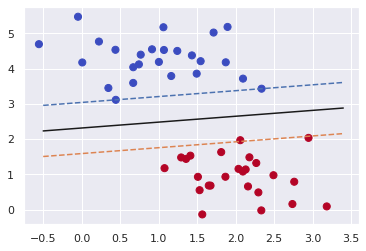

In [100]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')

center_fence= (-svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
upper_fence= (-1- svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
lower_fence= (1- svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]

plt.plot(X_fit, upper_fence, linestyle='dashed')
plt.plot(X_fit, center_fence, 'k'); 
plt.plot(X_fit,lower_fence, linestyle='dashed')

**새로운 데이터가 나타나면 $wx + b$를 구하여 sign을 확인**

**절대값이 클수록 점점 멀어져가고 있고 마치 확률처럼 생각하면 됨**

<img src= 'https://wikimedia.org/api/rest_v1/media/math/render/svg/cbb2c65f0f33af6f17bb6515a8843041625a3626'>

- '-1' 이하이면 파란색
- '1' 이상이면 빨강색
- '-1 ~ 1'사이면 분류를 하지 못함(margin error)

In [101]:
x0 = np.array([3, 10])
x1 = np.array([3, 5])
x2 = np.array([3, 1])
x3 = np.array([2, 2])
x4 = np.array([2, -5])

for x in [x0, x1, x2, x3, x4]:

  y_pred = b + w@x   # 

  if y_pred <= -1:
    print(f'인스턴스{x}에 파라미터(w, b) 적용한 SVM의 값은 : {b + w@x}, 빨강색 그룹에 속한다')

  if y_pred >= 1:
    print(f'인스턴스{x}에 파라미터(w, b) 적용한 SVM의 값은 : {b + w@x}, 파란색 그룹에 속한다')

  if -1 <= y_pred <= 1:
    print(f'인스턴스{x}에 파라미터(w, b) 적용한 SVM의 값은 : {b + w@x}, 모르겠다, margin error')

인스턴스[ 3 10]에 파라미터(w, b) 적용한 SVM의 값은 : [-9.89709282], 빨강색 그룹에 속한다
인스턴스[3 5]에 파라미터(w, b) 적용한 SVM의 값은 : [-3.0091797], 빨강색 그룹에 속한다
인스턴스[3 1]에 파라미터(w, b) 적용한 SVM의 값은 : [2.50115079], 파란색 그룹에 속한다
인스턴스[2 2]에 파라미터(w, b) 적용한 SVM의 값은 : [0.89389488], 모르겠다, margin error
인스턴스[ 2 -5]에 파라미터(w, b) 적용한 SVM의 값은 : [10.53697325], 파란색 그룹에 속한다


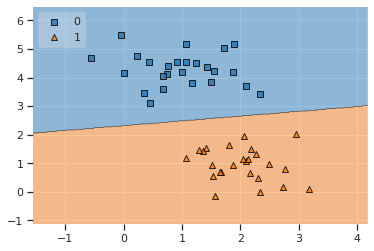

In [102]:
from mlxtend.plotting import plot_decision_regions # 2차원 특성변수의 분류경계선을 시각
fig= plot_decision_regions(X, y, clf=svc, legend=2)

**SVM 알고리즘의 특성**

- A large margin(wide street) contributes to a better **generalization**, that is how well the model will classify new examples in the future.
- 일반적인 알고리즘은 (1)번 알고리즘을 (2)번으로 이동시키면서 error rate를 zero로 만들지만 SVM은 모든 class에 대해 가장 멀리 위치하게 최적화

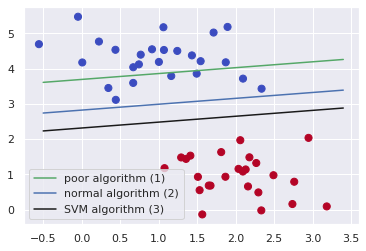

In [103]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
poor_al = (-1.9- svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
algorithm = (-0.7- svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
hyperplane = (-svc.intercept_ - svc.coef_[0][0]*X_fit)/svc.coef_[0][1]
plt.plot(X_fit, poor_al,'g', label = 'poor algorithm (1)'); 
plt.plot(X_fit, algorithm,'b', label = 'normal algorithm (2)'); 
plt.plot(X_fit, hyperplane, 'k', label = 'SVM algorithm (3)');
plt.legend()

## **3. Regularization**
**Hard or Soft margin**

- 일반화 모델(Generalized Model)기준에서는 오분류를 어느정도 인정하면서 Wide street (hyperparamet C가 적은 SVM)를 선택하는 것이 바람직함

<img src='https://hleecaster.com/wp-content/uploads/2020/01/svm06.png' width=600 height=400>

**What is Softmargin (C hyperparameter)?**

- C가 클수록 개별 인스턴스 class에 신경을 쓰면서(오류를 최소화) SVM을 찾게 되면 과적합(Overfitting)
- C가 작을수록 개별 인스턴스 class에 신경을 덜 쓰면서(오류를 어느 정도 인정) SVM을 찾게 되면 과적합(Underfitting)
- C를 hyperparamet tunning하면서 SVM을 찾는다.

<img src='https://miro.medium.com/max/1400/0*yOFKXNU24NBQRaA2.png'>

## **4. Kernel function**
- 쥬피터 스크립트 'appendix 3 basis function.ipynb' 참고

<img src='http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/img/topology_1D-2D_train.gif' width=600 height=400>

Text(0.5, 0, 'x1')

Text(0, 0.5, 'x2')

Text(0.5, 1.0, 'Problem')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


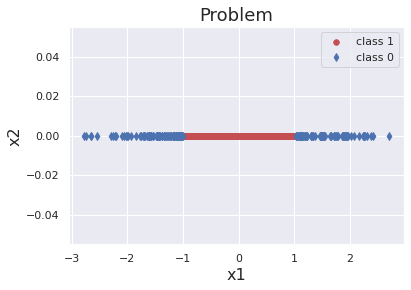

Text(0.5, 0, '$\\phi_1$')

Text(0, 0.5, '$\\phi_2$')

Text(0.5, 1.0, 'Problem solving in Transformed higer Space')

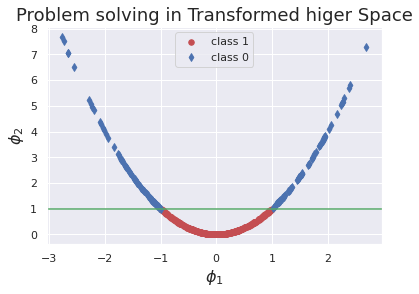

In [105]:
np.random.seed(0)
X = np.random.randn(500); tr = 1
X_pos = X[np.logical_and(X<tr, X>-tr)]; X_neg = X[np.logical_or(X>=tr, X<=-tr)]
plt.scatter(X_pos, y=X_pos*0, c='r', marker='o', label='class 1', s=30)
plt.scatter(X_neg, y=X_neg*0, c='b', marker='d', label='class 0', s=30)
plt.legend(); plt.xlabel('x1', fontsize='16'); plt.ylabel('x2', fontsize='16'); 
plt.title('Problem', fontsize='18');plt.show()

plt.scatter(X_pos, y=X_pos**2, c='r', marker='o', label='class 1', s=30)
plt.scatter(X_neg, y=X_neg**2, c='b', marker='d', label='class 0', s=30)
plt.legend(); plt.xlabel(r'$\phi_1$',fontsize='16'); plt.ylabel(r'$\phi_2$',fontsize='16')
plt.title('Problem solving in Transformed higer Space', fontsize='18')
plt.axhline(y= tr, color='g', linestyle='-')

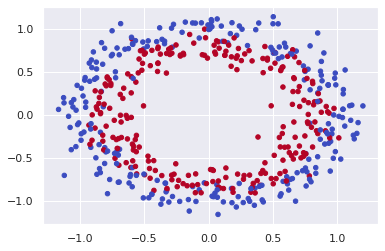

<Figure size 576x576 with 0 Axes>

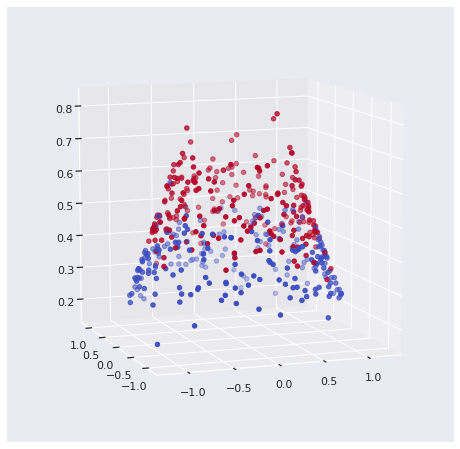

In [106]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=500, random_state=11, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm');plt.show()

from mpl_toolkits import mplot3d
r = np.exp(-(X ** 2).sum(1))
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], r, c=y, cmap='coolwarm')
ax.view_init(10, 250)

**Kernel density estimation**

https://en.wikipedia.org/wiki/Positive-definite_kernel

자료를 Gaussian RBF(Kernel)을 사용하여 pdf로 변환 
- Nonlinear SVM classification (Hands-on Macjine learning, O'RRELY Book)
     * x1  = 수열 자료(-5 ~ +5)
     * x2, x3 = x1자료에 해당되는 정규분포를 pdf 자료2, 3 생성자료

Text(0, 0.5, 'Similarity')

Text(0.5, 0, 'x1')

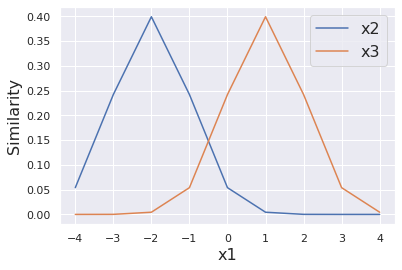

In [107]:
import scipy.stats as stats
x1 = np.arange(-4, 5, 1)
x2 = stats.norm.pdf(x1, -2, 1); x3 = stats.norm.pdf(x1, 1, 1)
data = pd.DataFrame(np.c_[x1, x2, x3], columns = ['x1', 'x2', 'x3'])
data.set_index('x1', inplace=True); data[['x2', 'x3']].plot()
plt.ylabel('Similarity', fontsize = 16); plt.xlabel("x1", fontsize = 16)
plt.legend(fontsize = 16)

Text(0, 0.5, 'x3')

Text(0.5, 0, 'x2')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


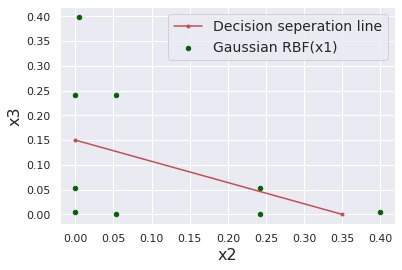

In [108]:
ax1 = data.plot.scatter(x='x2', y='x3', c='DarkGreen', label='Gaussian RBF(x1)')
plt.plot([0,0.35], [0.15,0.00], 'r.-', label='Decision seperation line')
plt.legend(fontsize = 14); plt.ylabel('x3', fontsize = 16); plt.xlabel("x2", fontsize = 16)

**Similarity (Likelihood)**
- TN와 TP의 영역에 있는 x1의 RBF변환값은 x2, x3가 둘중 하나는 '0'에 가까움
- FN와 FP의 영역에 있는 x1의 RBF변환값은 x2, x3가 모두 '0' 보다 상당히 크다
- if x1= -1,   x2=0.25, x3=0.05로 좌표 이동, 즉 x1=-1은 x2와 가깝다(similarity가 높다) 

## hyperparameter tunning

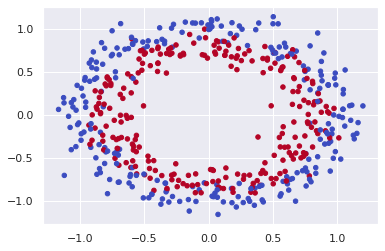

In [ ]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=500, random_state=11, noise=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')

Text(0.5, 1.0, "SVC(kernel='linear')")

Text(0.5, 1.0, 'SVC()')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


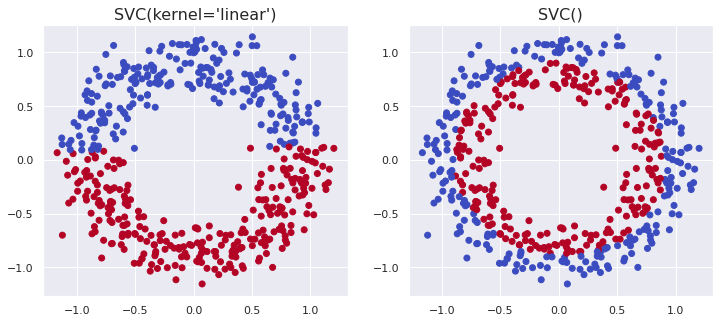

In [89]:
fig, axs = plt.subplots(1,2, figsize=(12, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.2)
axs = axs.ravel()
classifiers = [SVC(kernel='linear'), SVC(kernel='rbf')]
for i, classifier in enumerate(classifiers) :
    axs[i].set_title(classifier, fontsize='16')
    y_pred = classifier.fit(X, y).predict(X) 
    axs[i].scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm')

## **5. Hyperparameter Tunning**

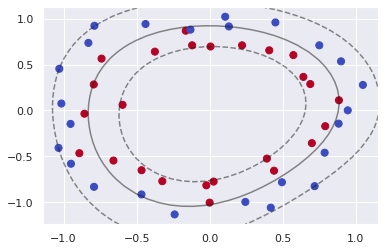

In [109]:
X, y = make_circles(n_samples=50, random_state=11, noise=0.1)
model = SVC(kernel='rbf')
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(model);

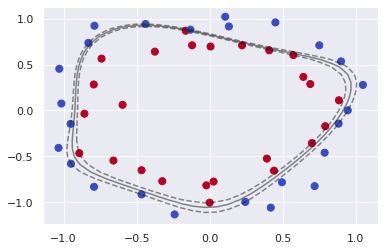

In [115]:
model = SVC(kernel='rbf', C=1E10) # model = SVC(kernel='rbf', C=1E10, probability=True)
model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='coolwarm')
plot_svc_decision_function(model);

In [116]:
model.predict_proba(X) # SVC(kernel='rbf', probability=True)

AttributeError: ignored

In [117]:
model.decision_function(X)

array([ 19.44321087,   5.37466278,   8.29027506,  -8.52733493,
        -1.46266158,   1.00028663,   8.24420066,   3.59936256,
        -0.99956068,  -0.99962784,  -2.46634641,   4.88641832,
       -12.84706896,   8.89783492,   2.6740324 ,  -6.14980969,
         0.99996122,   0.99954906,   1.59612202,  -2.32242341,
        -1.00039795,  -0.9998641 ,  -3.87488589,   6.33339901,
        -8.31401986, -21.59700621,  -6.16053702,  11.16398513,
         1.44054105,   5.33872744,   6.59491553,   1.85320244,
        -5.16876296,  -0.99975992,  -2.04099332,   6.25042161,
        20.73239141, -21.49623084,   0.9996241 ,   0.99955349,
        -1.02878794,  -2.88765083,  -1.00014568,  13.8245104 ,
        -5.39450019,  -0.99973912,  -0.99975277,   8.3891503 ,
        -3.01590426,   1.99949756])

# END